In [91]:
import pandas as pd

file1 = "EP6_RCVs_2022_06_13.xlsx"
file2 = "EP6_Voted docs.xlsx"
file3 = "EP7_RCVs_2014_06_19.xlsx"
file4 = "EP7_Voted docs.xlsx"
file5 = "EP8_RCVs_2019_06_25.xlsx"
file6 = "EP8_Voted docs.xlsx"
file7 = "EP9_RCVs_2022_06_22.xlsx"
file8 = "EP9_Voted docs.xlsx"

def read_excel_to_df(file, usecols=None, sheet=None):
    df = pd.read_excel(file, usecols=usecols)
    return df

def read_pickle_to_df(file):
    return pd.read_pickle(file)

def is_RCV_or_voted_docs(file):
    if "RCV" in file:
        return "RCV"
    elif "Voted docs" in file:
        return "Voted docs"
    
file_names = [
        file1,
        file2,
        file3,
        file4,
        file5,
        file6,
        file7,
        file8
    ]
   
# all files (if needed)
all_files = {file: is_RCV_or_voted_docs(file) for file in file_names}

In [ ]:

def filter_data(df, meta_cols, start_col):
    vote_cols = df.columns[start_col:]
    return df[meta_cols + list(vote_cols)]


filesRCV = []
for file in all_files:
    if all_files[file] == "RCV":
        filesRCV.append(file)

raw_data = {}
for file in filesRCV:
    raw_data[file] = read_pickle_to_df("pickled_data/" + file + ".pkl")

for key, val in raw_data.items():
    pass#(key, val.columns)

meta_cols = ["Column2", "Column7", "Column8", "Column9"]
filtered_data_1 = filter_data(raw_data[file1], meta_cols, 10)
filtered_data_1 = filtered_data_1[2:]


filtered_data_1 = filtered_data_1.rename(columns={
    "Column2": "WebisteEpID",
    "Column7": "Country",
    "Column8": "Party",
    "Column9": "EPG"})

start_col = 4

new_columns = list(filtered_data_1.columns[:start_col]) + list(range(1, len(filtered_data_1.columns) - start_col + 1))
filtered_data_1.columns = new_columns
#rint("1 ", filtered_data_1["Party"])


meta_cols = ["MEP ID", "Country", "EPG"]
filtered_data_2 = filter_data(raw_data[file3], meta_cols, 9)
filtered_data_2 = filtered_data_2.rename(columns={
    "MEP ID": "WebisteEpID"})

#print("2 ", filtered_data_2.columns)

meta_cols = ["WebisteEpID", "Country", "EPG"]

filtered_data_3 = filter_data(raw_data[file5], meta_cols, 9)
#print("3 ",filtered_data_3.columns)

filtered_data_4 = filter_data(raw_data[file7], meta_cols, 10)
#print("4 ", filtered_data_4.columns)


1  2      Anorthotiko Komma Ergazomenou Laou - Aristera ...
3                                   Liga Polskich Rodzin
4      Partito della Rifondazione Comunista - Sinistr...
5                                           Forza Italia
6                                   Traditional Unionist
                             ...                        
937                             Partidul Social Democrat
938                             Partidul Social Democrat
939                            Partidul Democrat-Liberal
940                                      Partido Popular
941                                        Jaunais laiks
Name: Party, Length: 940, dtype: object


In [199]:
""" Encoding from legend sheet:
0 - not a MEP
1 - for
2 - against
3 - abstention
4 - absent
5 - didn't vote
6 - motivated
"""

import numpy as np

def encode_votes(votes_categorical):
    votes_encoded = np.zeros_like(votes_categorical)

    votes_encoded[votes_categorical == 1] = 1   # for
    votes_encoded[votes_categorical == 2] = -1  # against
    return votes_encoded

def encode_votes_strict(votes_categorical):
    votes_encoded = np.ones_like(votes_categorical) * -1

    votes_encoded[votes_categorical == 1] = 1   # for is 1, everythingn else -1
    return votes_encoded


def compute_cosine_similarity_mtx(votes_encoded):
    norms = np.linalg.norm(votes_encoded, axis=1, keepdims=True)
    norms[norms == 0] = 1    # avoid division by zero

    votes_norm = votes_encoded / norms
    S = votes_norm @ votes_norm.T
    return S

def compute_MDS(S, k=1, eps=0.0):
    n = S.shape[0]
    D2 = (1.0 - S)
    np.fill_diagonal(D2, 0.0)
    D2 = np.maximum(D2, 0.0)

    J = np.eye(n) - np.ones((n, n)) / n
    B = -0.5 * (J @ D2 @ J)

    evals, evecs = np.linalg.eigh(B)
    idx = np.argsort(evals)[::-1]
    evals = evals[idx]
    evecs = evecs[:, idx]

    # Keep only positive eigenvalues
    pos = evals > eps
    evals_pos = evals[pos]
    evecs_pos = evecs[:, pos]

    if evals_pos.size < k:
        raise ValueError(
            f"Not enough positive eigenvalues to build k={k} dims "
            f"(found {evals_pos.size}). Consider a different distance mapping or k."
        )

    Lk = np.diag(np.sqrt(evals_pos[:k]))
    Vk = evecs_pos[:, :k]
    explained = evals / evals.sum()
    print(explained[:5])

    # Coordinates: X = V_k * sqrt(Lambda_k)
    X = Vk @ Lk
    return X, evals

def process_and_compute_MDS(filtered_data, name):
    colors = filtered_data[["WebisteEpID", "Country", "EPG"]][:]

    # enforce string
    colors["EPG"] = colors["EPG"].fillna("Unknown").astype(str)
    colors["Country"] = colors["Country"].fillna("Unknown").astype(str)

    votes_categorical = np.array(filtered_data.loc[:, 1:])

    #compute similarity matrix for file3
    votes_encoded = encode_votes(votes_categorical)
    S = compute_cosine_similarity_mtx(votes_encoded)
    print(S.shape)

    X, evals = compute_MDS(S, k=2)
    print(X.shape)
    return {"name": name,
            "X": X,
            "evals": evals,
            "colors": colors
            }

def k_nearest_neighbors(S, k=20):
    n = S.shape[0]
    S = np.maximum(S, 0.0)

    W = np.zeros_like(S)

    for i in range(n):
        idx = np.argsort(S[i])[-k-1:-1]  # top-k neighbors 
        W[i, idx] = S[i, idx]

    # make graph symmetric
    W = np.maximum(W, W.T)

    return W

def spectral_embedding(votes, k=20):

    S = compute_cosine_similarity_mtx(votes)
    X, eigvals = build_graph(S, k=k)

    return X, eigvals

def compute_mean_of_groups(votes, color):
    groups = set(color[1:])
    print(groups)

    group_means = {}
    for group in groups:
        mask = (color == group)
        group_means[group] = np.mean(votes[mask], axis=0)
    return group_means

def compute_diff_from_groupmean(votes, colors, groupmeans):
    votes_cp = votes.copy()
    for group, mean in groupmeans.items():
        mask = (colors == group)
        votes_cp[mask] = votes_cp[mask] - mean
    return votes_cp

def build_graph(S, k=20):
    n = S.shape[0]
    # build weights/edges matrix
    W = k_nearest_neighbors(S, k=k)

    # build degree matrix
    deg = W.sum(axis=1)
    print(deg)
    print(min(deg))

    eps = 1e-12
    D_inv_sqrt = np.diag(1.0 / (np.sqrt(deg)+ eps))
    L = np.eye(n) - D_inv_sqrt @ W @ D_inv_sqrt

    eigvals, eigvecs = np.linalg.eigh(L)

    X = eigvecs[:, 1:3]   # shape (n_meps, 2)

    return X, eigvals

def run_mean_comp(votes, colors, k=20):
    group_means = compute_mean_of_groups(votes, colors)
    votes_res = compute_diff_from_groupmean(votes, colors, group_means)

    S = compute_cosine_similarity_mtx(votes_res)
    #X, evals = compute_MDS(S, k=2)
    X, evals = build_graph(S, k=k)
   
    return X, evals


filtered_datas = [filtered_data_1, filtered_data_2, filtered_data_3, filtered_data_4]
results = []

#for i, filtered_data in enumerate(filtered_datas):
#result = process_and_compute_MDS(filtered_data_1, "mds")
#results.append(result)


#X, eigvals = spectral_embedding(filtered_data_1)
meta_cols = ["WebisteEpID", "Country", "EPG", "Party"]

colors = filtered_data_1[meta_cols][:]
vote_cols = filtered_data_1.columns.difference(
        meta_cols
    )
votes = np.array(filtered_data_1[vote_cols])
#votes_encoded = encode_votes_strict(votes)
votes_encoded = encode_votes(votes)

# enforce string
colors["EPG"] = colors["EPG"].fillna("Unknown").astype(str)
colors["Country"] = colors["Country"].fillna("Unknown").astype(str)

X, evals = run_mean_comp(votes_encoded, colors["EPG"], k=50)
res_result = {"name": "residual",
                "X": X,
                "evals": evals,
                "colors": colors
                }


X, eigvals = spectral_embedding(votes_encoded, k=20)
graph_result = {"name": "graph_embedding",
                "X": X,
                "evals": eigvals,
                "colors": colors}



{'Socialist Group in the European Parliament', 'Group of the Greens/European Free Alliance', 'Union for Europe of the Nations Group', 'Non-attached Members', "Group of the European People's Party (Christian Democrats) and European Democrats", 'Confederal Group of the European United Left - Nordic Green Left', 'Independence/Democracy Group', 'Group of the Alliance of Liberals and Democrats for Europe'}
[ 3.382456    9.16053057 10.6561666  17.69115601 14.00283325 12.57510935
 11.94266395 19.80379318 15.14537767 16.002021    8.25606177 18.79859784
 15.42173123  9.79564389 26.07121178  4.53082674 24.10297362  5.6884411
 17.88421373  5.9034905   3.97565365 18.68645567 10.73429071 14.73499873
 27.86843356 14.34475839 18.30013564  8.38517308 17.17497348 17.78359994
 10.60864391  7.03717067 26.97912215 15.73477691 12.60723423 25.97197068
  8.3383478  26.71333453 13.26183848 11.90388599 37.82196717  4.30797908
  6.22195495 41.78324116 14.48005104 24.29130202 20.02849175  8.57836703
  7.29951195

/tmp/ipykernel_39315/1902796081.py:22: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(pad=2)


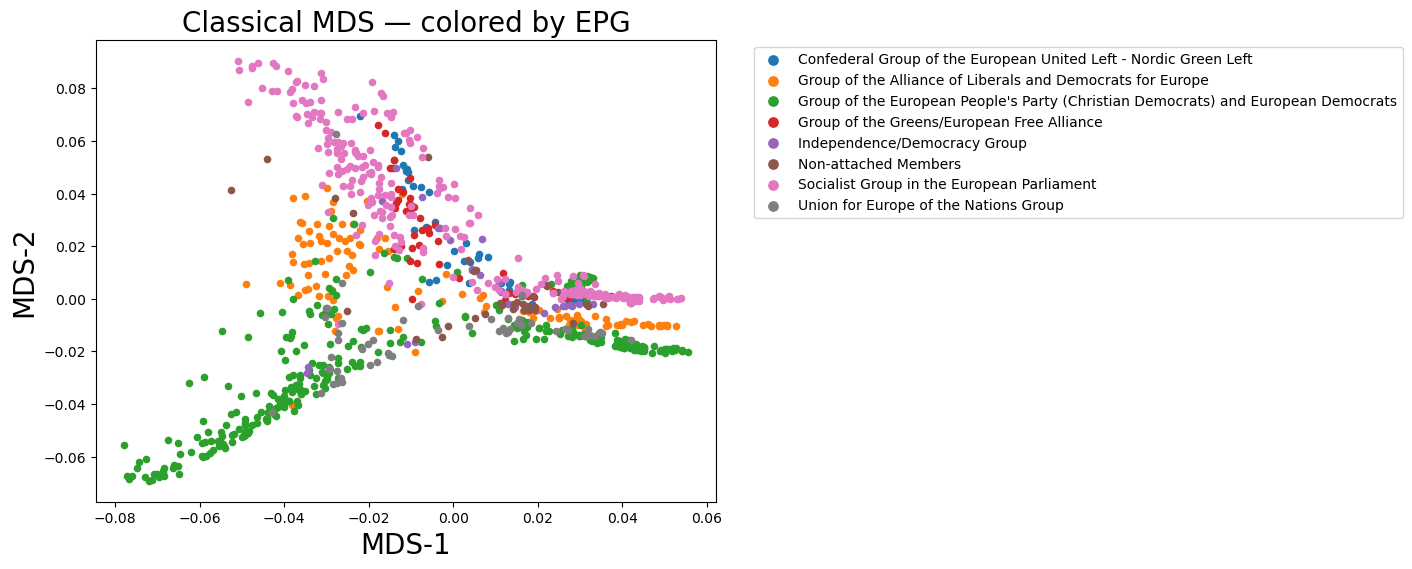

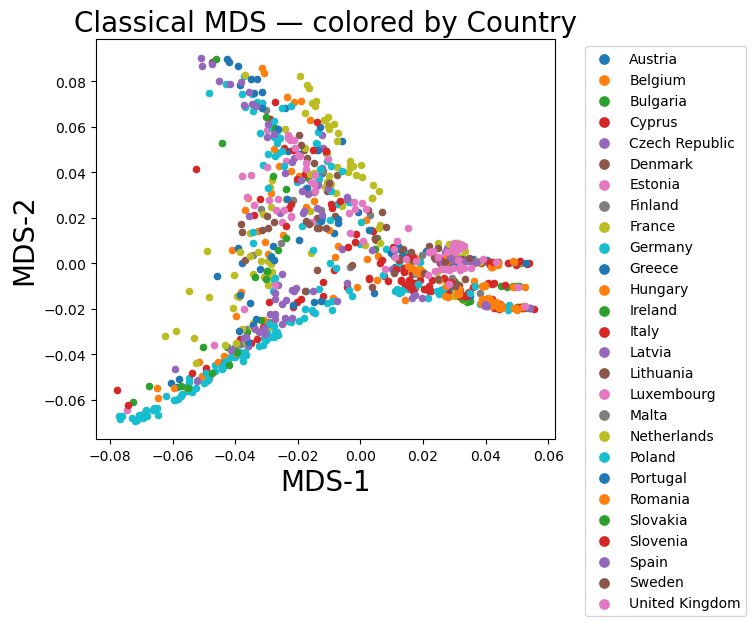

MDS summary for dataset: residual
------------------------------------------------------------
Number of MEPs           : 940
Explained variance (MDS-1): 0.00%
Explained variance (MDS-2): 0.00%
Explained variance (1+2)  : 0.00%


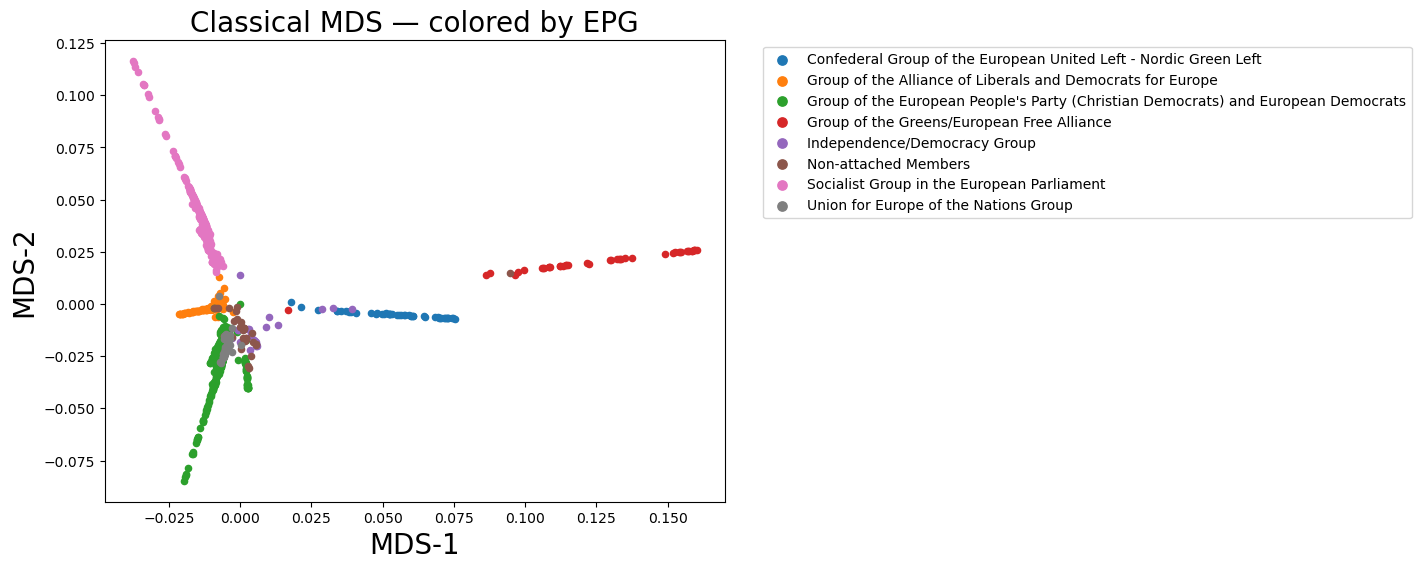

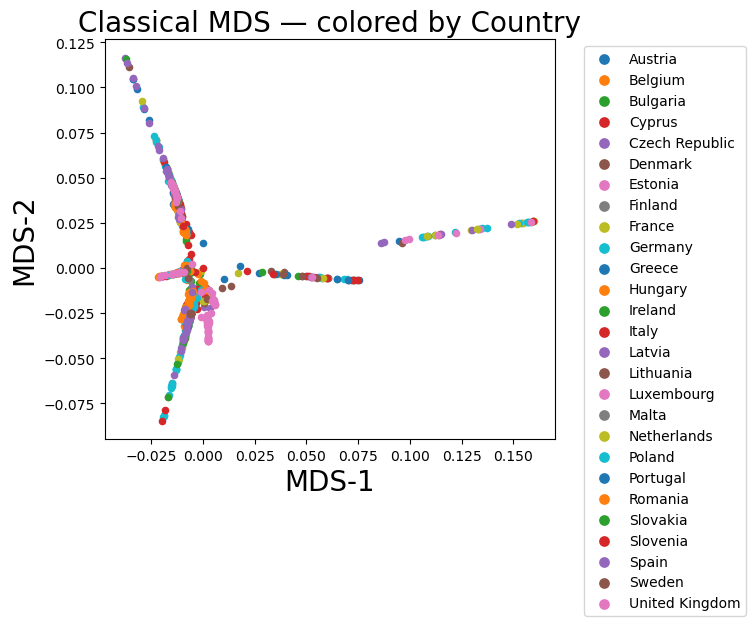

MDS summary for dataset: graph_embedding
------------------------------------------------------------
Number of MEPs           : 940
Explained variance (MDS-1): 0.00%
Explained variance (MDS-2): 0.00%
Explained variance (1+2)  : 0.00%


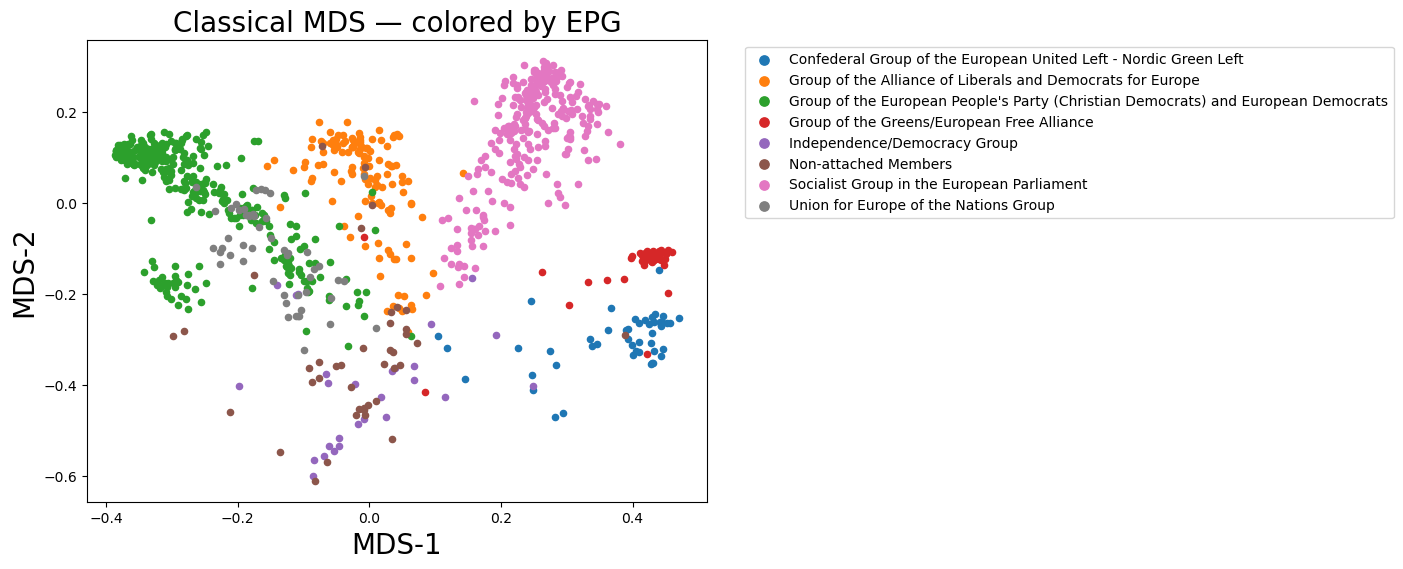

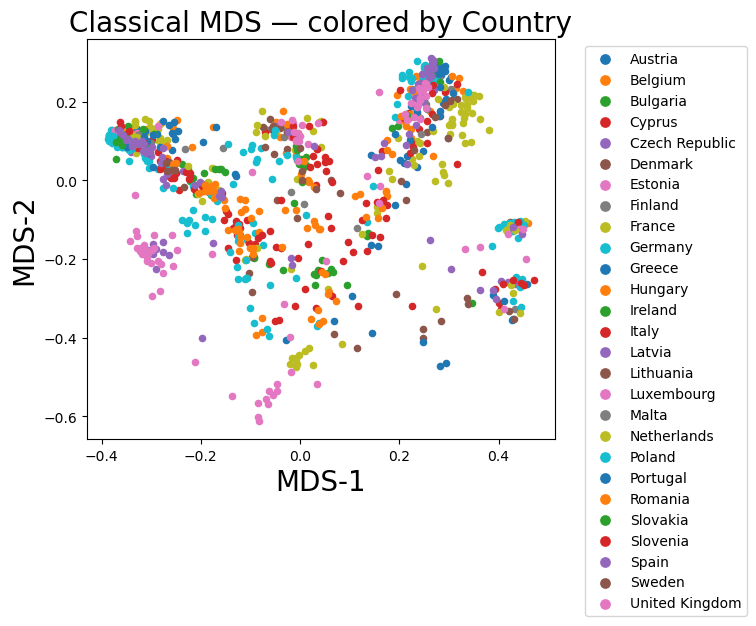

MDS summary for dataset: mds
------------------------------------------------------------
Number of MEPs           : 940
Explained variance (MDS-1): 17.02%
Explained variance (MDS-2): 9.26%
Explained variance (1+2)  : 26.28%


In [202]:
import matplotlib.pyplot as plt


def plot_by_EPG(epg_labels, X, size=20, filename="plot_by_epg.png", save=False):

    plt.figure(figsize=(8, 6))
    if X.shape[1] == 2:
        for epg in np.unique(epg_labels):
            mask = epg_labels == epg
            plt.scatter(X[mask, 0], X[mask, 1], label=epg, s=20)
    else:
        for c in np.unique(epg_labels):
            mask = epg_labels == c
            plt.scatter(X[mask], np.zeros_like(X[mask]), label=c, s=20)

    plt.legend(markerscale=1.5, bbox_to_anchor=(1.05, 1), loc="upper left")
    #plt.xlim(-5, 5)

    plt.title("Classical MDS — colored by EPG", fontsize=size)
    plt.xlabel("MDS-1", fontsize=size)
    plt.ylabel("MDS-2", fontsize=size)
    plt.tight_layout(pad=2)

    if save:
        plt.savefig(filename)
    plt.show()

def plot_by_country(country_labels, X, size=20, filename="plot_by_country.png", save=False):
    plt.figure(figsize=(8, 6))
    if X.shape[1] == 2:
        for c in np.unique(country_labels):
            mask = country_labels == c
            plt.scatter(X[mask, 0], X[mask, 1], label=c, s=20)

    else:
        for c in np.unique(country_labels):
            mask = country_labels == c
            plt.plot(X[mask], np.zeros_like(X[mask]), label=c, s=20)

    plt.legend(markerscale=1.5, bbox_to_anchor=(1.05, 1), loc="upper left")#, fontsize=18)
    plt.title("Classical MDS — colored by Country", fontsize=size)
    plt.xlabel("MDS-1", fontsize=size)
    plt.ylabel("MDS-2", fontsize=size)
    plt.tight_layout(pad=2)

    if save:
        plt.savefig(filename)
    plt.show()


def explained_variance(evals, k=2):
    evals = np.asarray(evals)
    total = evals.sum()
    return evals[:k] / total

def print_mds_summary(name, X, evals):
    n_points = X.shape[0]
    explained = explained_variance(evals, k=2)

    print("=" * 60)
    print(f"MDS summary for dataset: {name}")
    print("-" * 60)
    print(f"Number of MEPs           : {n_points}")
    print(f"Explained variance (MDS-1): {explained[0]*100:.2f}%")
    print(f"Explained variance (MDS-2): {explained[1]*100:.2f}%")
    print(f"Explained variance (1+2)  : {(explained[:2].sum())*100:.2f}%")
    print("=" * 60)


def plot_results(result):
    colors = result["colors"]
    X = result["X"]
    name = str(result["name"])
    evals = result["evals"]

    epg_labels = colors["EPG"].to_numpy()
    plot_by_EPG(epg_labels, X, filename=f"plot_by_epg_{name}.png", save=True)

    country_labels = colors["Country"].to_numpy()
    plot_by_country(country_labels, X, filename=f"plot_by_country_{name}.png", save=True)

    print_mds_summary(name, X, evals)


plot_results(res_result)
plot_results(graph_result)
plot_results(result)
#for result in results:
#    plot_results(result)
